# Compare model performances and Ground turths

In the test set we left a few data point s with double annotations. This allows us to compare ho the model performs with respect to the each one of the annotators. In addition we can compare simultaneously one model and one annotator vrt the other annotator. This way we can see if there is still some improvement left in the model, of if the error is due to aleatoric uncertainty.

In [1]:
import os

import torch
import pandas as pd
import shutil
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from src.model.model import maskRCNNModel
from src.model.engine import FitterMaskRCNN
from src.model.dataset import MaskRCNNDataset
from src.model.mrcnn_utils import *
from src.utils.utils import *
from src.utils.const import *
from src.utils.data_utils import *

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [20]:
fine_tuned_model_path = "../weights/best-checkpoint-fine-tune-no-aug.bin" # don't use for now
fine_tuned_model_aug_path = "../weights/best-checkpoint-fine-tune-aug.bin"
original_model_path = "../weights/best-checkpoint-114epoch.bin"
test_dataset_path = "../dataset/test"
# confidence_thresholds = [0., 0.5, 0.7, 0.8, 0.9, 0.95]
confidence_thresholds = [0.8, 0.9]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Divide the instances based on the annotator

In [3]:
images_paths = get_images_paths(test_dataset_path)
annotations_to_image_paths = get_annotations_paths(images_paths, test_dataset_path)
test_dataset_path_1 = "test_1"
test_dataset_path_2 = "test_2"
test_dataset_path_3 = "test_3"
for image_path, annotation_path in zip(images_paths, annotations_to_image_paths):
    annotation = pd.read_csv(annotation_path, sep=',', index_col=0)
    image_rel_path = os.path.relpath(image_path, test_dataset_path)
    annotation_rel_path = os.path.relpath(annotation_path, test_dataset_path)
    if "annotator" not in annotation.columns:
        image_path_3 = os.path.join(test_dataset_path_3, image_rel_path)
        annotation_path_3 = os.path.join(test_dataset_path_3, annotation_rel_path)
        os.makedirs(os.path.dirname(image_path_3), exist_ok=True)
        os.makedirs(os.path.dirname(annotation_path_3), exist_ok=True)
        shutil.copyfile(image_path, image_path_3)
        annotation.to_csv(annotation_path_3)
        continue
    annotation_1 = annotation[annotation["annotator"] == 1]
    annotation_2 = annotation[annotation["annotator"] == 2]
    image_path_1 = os.path.join(test_dataset_path_1, image_rel_path)
    image_path_2 = os.path.join(test_dataset_path_2, image_rel_path)
    annotation_path_1 = os.path.join(test_dataset_path_1, annotation_rel_path)
    annotation_path_2 = os.path.join(test_dataset_path_2, annotation_rel_path)
    os.makedirs(os.path.dirname(image_path_1), exist_ok=True)
    os.makedirs(os.path.dirname(image_path_2), exist_ok=True)
    os.makedirs(os.path.dirname(annotation_path_1), exist_ok=True)
    os.makedirs(os.path.dirname(annotation_path_2), exist_ok=True)
    shutil.copyfile(image_path, image_path_1)
    shutil.copyfile(image_path, image_path_2)
    annotation_1.to_csv(annotation_path_1)
    annotation_2.to_csv(annotation_path_2)


In [4]:
collate_fn = lambda x: tuple(zip(*x))
test_dataset_1 = MaskRCNNDataset(dataset_path=test_dataset_path_1, datatype="eval", data_augmentation=False)
test_loader_1 = torch.utils.data.DataLoader(
    test_dataset_1,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)
test_dataset_2 = MaskRCNNDataset(dataset_path=test_dataset_path_2, datatype="eval", data_augmentation=False)
test_loader_2 = torch.utils.data.DataLoader(
    test_dataset_2,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)
test_dataset_3 = MaskRCNNDataset(dataset_path=test_dataset_path_3, datatype="eval", data_augmentation=False)
test_loader_3 = torch.utils.data.DataLoader(
    test_dataset_3,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
)

engine = FitterMaskRCNN(device)

fine_tuned_model = maskRCNNModel()
checkpoint = torch.load(fine_tuned_model_path, map_location=device) 
fine_tuned_model.load_state_dict(checkpoint['model_state_dict'])
fine_tuned_model.to(device)

fine_tuned_model_aug = maskRCNNModel()
checkpoint = torch.load(fine_tuned_model_aug_path, map_location=device) 
fine_tuned_model_aug.load_state_dict(checkpoint['model_state_dict'])
fine_tuned_model_aug.to(device)

original_model = maskRCNNModel()
checkpoint = torch.load(original_model_path, map_location=device)
original_model.load_state_dict(checkpoint['model_state_dict'])
original_model.to(device)


/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_75211/1999643737.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

Evaluate the fine tuned model

In [5]:
pred_ft_1, map_ft_1 = engine.evaluate_one_epoch_predictions(fine_tuned_model, test_loader_1, 0)
pred_ft_2, map_ft_2 = engine.evaluate_one_epoch_predictions(fine_tuned_model, test_loader_2, 0)
pred_ft_3, map_ft_3 = engine.evaluate_one_epoch_predictions(fine_tuned_model, test_loader_3, 0)

100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


Evalate the fina tuned model with augmentation

In [6]:
pred_ft_aug_1, map_ft_aug_1 = engine.evaluate_one_epoch_predictions(fine_tuned_model_aug, test_loader_1, 0)
pred_ft_aug_2, map_ft_aug_2 = engine.evaluate_one_epoch_predictions(fine_tuned_model_aug, test_loader_2, 0)
pred_ft_aug_3, map_ft_aug_3 = engine.evaluate_one_epoch_predictions(fine_tuned_model_aug, test_loader_3, 0)

100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Evaluate the original model

In [7]:
pred_orig_1, map_orig_1 = engine.evaluate_one_epoch_predictions(original_model, test_loader_1, 0)
pred_orig_2, map_orig_2 = engine.evaluate_one_epoch_predictions(original_model, test_loader_2, 0)
pred_orig_3, map_orig_3 = engine.evaluate_one_epoch_predictions(original_model, test_loader_3, 0)


100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


In [16]:
map = pd.DataFrame(columns=["test_1", "test_2", "test_3", "test"])
map.loc["fine_tuned_model"] = [map_ft_1["map"].item(), map_ft_2["map"].item(), map_ft_3["map"].item(), (map_ft_1["map"].item() + map_ft_2["map"].item() + map_ft_3["map"].item()) / 3]
map.loc["fine_tuned_model_aug"] = [map_ft_aug_1["map"].item(), map_ft_aug_2["map"].item(), map_ft_aug_3["map"].item(), (map_ft_aug_1["map"].item() + map_ft_aug_2["map"].item() + map_ft_aug_3["map"].item()) / 3]
map.loc["original_model"] = [map_orig_1["map"].item(), map_orig_2["map"].item(), map_orig_3["map"].item(), (map_orig_1["map"].item() + map_orig_2["map"].item() + map_orig_3["map"].item()) / 3]
print("map")
display(map)
map_50 = pd.DataFrame(columns=["test_1", "test_2", "test_3", "test"])
map_50.loc["fine_tuned_model"] = [map_ft_1["map_50"].item(), map_ft_2["map_50"].item(), map_ft_3["map_50"].item(), (map_ft_1["map_50"].item() + map_ft_2["map_50"].item() + map_ft_3["map_50"].item()) / 3]
map_50.loc["fine_tuned_model_aug"] = [map_ft_aug_1["map_50"].item(), map_ft_aug_2["map_50"].item(), map_ft_aug_3["map_50"].item(), (map_ft_aug_1["map_50"].item() + map_ft_aug_2["map_50"].item() + map_ft_aug_3["map_50"].item()) / 3]
map_50.loc["original_model"] = [map_orig_1["map_50"].item(), map_orig_2["map_50"].item(), map_orig_3["map_50"].item(), (map_orig_1["map_50"].item() + map_orig_2["map_50"].item() + map_orig_3["map_50"].item()) / 3]
print("map_50")
display(map_50)
mar_100 = pd.DataFrame(columns=["test_1", "test_2", "test_3", "test"])
mar_100.loc["fine_tuned_model"] = [map_ft_1["mar_100"].item(), map_ft_2["mar_100"].item(), map_ft_3["mar_100"].item(), (map_ft_1["mar_100"].item() + map_ft_2["mar_100"].item() + map_ft_3["mar_100"].item()) / 3]
mar_100.loc["fine_tuned_model_aug"] = [map_ft_aug_1["mar_100"].item(), map_ft_aug_2["mar_100"].item(), map_ft_aug_3["mar_100"].item(), (map_ft_aug_1["mar_100"].item() + map_ft_aug_2["mar_100"].item() + map_ft_aug_3["mar_100"].item()) / 3]
mar_100.loc["original_model"] = [map_orig_1["mar_100"].item(), map_orig_2["mar_100"].item(), map_orig_3["mar_100"].item(), (map_orig_1["mar_100"].item() + map_orig_2["mar_100"].item() + map_orig_3["mar_100"].item()) / 3]
print("mar_100")
display(mar_100)


map


,test_1,test_2,test_3,test
fine_tuned_model,0.409448,0.416663,0.395258,0.407123
fine_tuned_model_aug,0.406927,0.413406,0.394559,0.404964
original_model,0.213916,0.215905,0.274119,0.234647


map_50


,test_1,test_2,test_3,test
fine_tuned_model,0.619953,0.607740,0.571719,0.599804
fine_tuned_model_aug,0.626444,0.614299,0.575191,0.605311
original_model,0.314953,0.309963,0.373342,0.332752


mar_100


,test_1,test_2,test_3,test
fine_tuned_model,0.470571,0.485784,0.430492,0.462282
fine_tuned_model_aug,0.464000,0.478675,0.427652,0.456776
original_model,0.387429,0.397092,0.354924,0.379815


In [9]:
from scipy.optimize import linear_sum_assignment
from copy import deepcopy

def compute_iou(box_1, box_2):
    # compute the iou of two boxes
    x1 = max(box_1[0], box_2[0])
    y1 = max(box_1[1], box_2[1])
    x2 = min(box_1[2], box_2[2])
    y2 = min(box_1[3], box_2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box_1 = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    area_box_2 = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    union = area_box_1 + area_box_2 - intersection
    return intersection / union if union > 0 else 0

def compute_iou_matrix(bboxes_1, bboxes_2, ):
    # compute the iou matrix
    iou_matrix = np.zeros((len(bboxes_1), len(bboxes_2)))
    for i, box_1 in enumerate(bboxes_1):
        for j, box_2 in enumerate(bboxes_2):
            iou_matrix[i, j] = compute_iou(box_1, box_2)
    return iou_matrix


def instance_matcher(iou_matrix, iou_threshold: float = 0.75):
    # filter out the matches with low iou
    iou_matrix[iou_matrix < iou_threshold] = 0
    # Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(iou_matrix, maximize=True)
    # fileter out the matches (some of them might be an artifact of the Hungarian algorithm)
    row_ind_threshold = []
    col_ind_threshold = []
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            row_ind_threshold.append(i)
            col_ind_threshold.append(j)
    return row_ind_threshold, col_ind_threshold

def ap(pred_boxes, target_boxes, iou_thresholds: list):
    iou_matrix = compute_iou_matrix(pred_boxes, target_boxes)
    precision = 0.
    recall = 0.
    for iou_threshold in iou_thresholds:
        row_ind, col_ind = instance_matcher(deepcopy(iou_matrix), iou_threshold)
        # filter out the matches
        tp = len(row_ind)
        fp = len(pred_boxes) - tp
        fn = len(target_boxes) - tp
        # compute the precision and recall
        precision += tp / (tp + fp) if (tp + fp) > 0 else 0
        recall += tp / (tp + fn) if (tp + fn) > 0 else 0
    precision /= len(iou_thresholds)
    recall /= len(iou_thresholds)
    return precision, recall

def map(preds, targets, iou_thresholds: list, confidece_threshold: float = 0.5):
    # compute the mean average precision
    precision = 0.
    recall = 0.
    preds = FitterMaskRCNN.filter_predicitons(preds, confidece_threshold)
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        target_boxes = target['boxes'].cpu().numpy()
        p, r = ap(pred_boxes, target_boxes, iou_thresholds)
        precision += p
        recall += r
    precision /= len(preds)
    recall /= len(preds)
    return precision, recall

In [10]:
images_1, target_1 = collate_fn([test_dataset_1[i] for i in range(len(test_dataset_1))])
images_2, target_2 = collate_fn([test_dataset_2[i] for i in range(len(test_dataset_2))])
images_3, target_3 = collate_fn([test_dataset_3[i] for i in range(len(test_dataset_3))])

for t_1, t_2 in zip(target_1, target_2):
    t_1['scores'] = torch.ones(len(t_1['area']), device=device)
    t_2['scores'] = torch.ones(len(t_2['area']), device=device)

for conf in confidence_thresholds:
    print(f"confidence threshold: {conf}")
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    pr_ft_1, rec_ft_1 = map(pred_ft_1, target_1, iou_thresholds, conf)
    pr_ft_2, rec_ft_2 = map(pred_ft_2, target_2, iou_thresholds, conf)
    pr_ft_aug_1, rec_ft_aug_1 = map(pred_ft_aug_1, target_1, iou_thresholds, conf)
    pr_ft_aug_2, rec_ft_aug_2 = map(pred_ft_aug_2, target_2, iou_thresholds, conf)
    pr_orig_1, rec_orig_1 = map(pred_orig_1, target_1, iou_thresholds, conf)
    pr_orig_2, rec_orig_2 = map(pred_orig_2, target_2, iou_thresholds, conf)
    pr_1_2, rec_1_2 = map(target_1, target_2, iou_thresholds, conf)
    pr_2_1, rec_2_1 = map(target_2, target_1, iou_thresholds, conf)
    df = pd.DataFrame({
        "prediction": ["fine-tuned", "fine-tuned", "fine-tuned-aug", "fine-tuned-aug", "original", "original", "test_2", "test_1",],
        "target": ["test_1", "test_2", "test_1", "test_2", "test_1", "test_2", "test_1", "test_2",],
        "precision": [pr_ft_1, pr_ft_2, pr_ft_aug_1, pr_ft_aug_2, pr_orig_1, pr_orig_2, pr_2_1, pr_1_2],
        "recall": [rec_ft_1, rec_ft_2, rec_ft_aug_1, rec_ft_aug_2, rec_orig_1, rec_orig_2, rec_2_1, rec_1_2],
    })
    display(df)


confidence threshold: 0.0


,prediction,target,precision,recall
0,fine-tuned,test_1,0.383905,0.466866
1,fine-tuned,test_2,0.353501,0.479439
2,fine-tuned-aug,test_1,0.360287,0.465895
3,fine-tuned-aug,test_2,0.329387,0.472360
4,original,test_1,0.260269,0.372229
5,original,test_2,0.237577,0.375172
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


confidence threshold: 0.5


,prediction,target,precision,recall
0,fine-tuned,test_1,0.425221,0.433997
1,fine-tuned,test_2,0.392874,0.450177
2,fine-tuned-aug,test_1,0.422898,0.447741
3,fine-tuned-aug,test_2,0.384392,0.453805
4,original,test_1,0.307956,0.355525
5,original,test_2,0.280144,0.361038
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


confidence threshold: 0.7


,prediction,target,precision,recall
0,fine-tuned,test_1,0.466878,0.415021
1,fine-tuned,test_2,0.435970,0.438375
2,fine-tuned-aug,test_1,0.478363,0.425038
3,fine-tuned-aug,test_2,0.437450,0.439202
4,original,test_1,0.331369,0.331741
5,original,test_2,0.305343,0.339155
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


confidence threshold: 0.8


,prediction,target,precision,recall
0,fine-tuned,test_1,0.501428,0.387837
1,fine-tuned,test_2,0.472456,0.410681
2,fine-tuned-aug,test_1,0.512933,0.387246
3,fine-tuned-aug,test_2,0.467963,0.401004
4,original,test_1,0.355842,0.307638
5,original,test_2,0.333563,0.320547
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


confidence threshold: 0.9


,prediction,target,precision,recall
0,fine-tuned,test_1,0.555741,0.330358
1,fine-tuned,test_2,0.521662,0.353363
2,fine-tuned-aug,test_1,0.556137,0.339155
3,fine-tuned-aug,test_2,0.510036,0.358822
4,original,test_1,0.407026,0.261057
5,original,test_2,0.386877,0.276745
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


confidence threshold: 0.95


,prediction,target,precision,recall
0,fine-tuned,test_1,0.594395,0.271838
1,fine-tuned,test_2,0.558615,0.292514
2,fine-tuned-aug,test_1,0.610380,0.280763
3,fine-tuned-aug,test_2,0.577969,0.304803
4,original,test_1,0.418908,0.203594
5,original,test_2,0.387500,0.214456
6,test_2,test_1,0.725893,0.646445
7,test_1,test_2,0.646445,0.725893


## Do the same as above but in terms of accuracy of area prediciton

In [21]:
area = {}
count = {}
for conf in confidence_thresholds:
    area[conf] = {}
    count[conf] = {}
    pred_ft_temp_1 = FitterMaskRCNN.filter_predicitons(pred_ft_1, conf)
    pred_ft_temp_2 = FitterMaskRCNN.filter_predicitons(pred_ft_2, conf)
    pred_ft_temp_3 = FitterMaskRCNN.filter_predicitons(pred_ft_3, conf)
    pred_ft_temp = pred_ft_temp_1 + pred_ft_temp_2 + pred_ft_temp_3
    area[conf]["ft_1"] = [masks_to_area(p["masks"]) for p in pred_ft_temp_1]
    area[conf]["ft_2"] = [masks_to_area(p["masks"]) for p in pred_ft_temp_2]
    area[conf]["ft_3"] = [masks_to_area(p["masks"]) for p in pred_ft_temp_3]
    area[conf]["ft"] = area[conf]["ft_1"] + area[conf]["ft_2"] + area[conf]["ft_3"]
    count[conf]["ft_1"] = [len(p['masks']) for p in pred_ft_temp_1]
    count[conf]["ft_2"] = [len(p['masks']) for p in pred_ft_temp_2]
    count[conf]["ft_3"] = [len(p['masks']) for p in pred_ft_temp_3]
    count[conf]["ft"] = count[conf]["ft_1"] + count[conf]["ft_2"] + count[conf]["ft_3"]
    pred_ft_aug_temp_1 = FitterMaskRCNN.filter_predicitons(pred_ft_aug_1, conf)
    pred_ft_aug_temp_2 = FitterMaskRCNN.filter_predicitons(pred_ft_aug_2, conf)
    pred_ft_aug_temp_3 = FitterMaskRCNN.filter_predicitons(pred_ft_aug_3, conf)
    pred_ft_aug_temp = pred_ft_aug_temp_1 + pred_ft_aug_temp_2 + pred_ft_aug_temp_3
    area[conf]["ft_aug_1"] = [masks_to_area(p["masks"]) for p in pred_ft_aug_temp_1]
    area[conf]["ft_aug_2"] = [masks_to_area(p["masks"]) for p in pred_ft_aug_temp_2]
    area[conf]["ft_aug_3"] = [masks_to_area(p["masks"]) for p in pred_ft_aug_temp_3]
    area[conf]["ft_aug"] = area[conf]["ft_aug_1"] + area[conf]["ft_aug_2"] + area[conf]["ft_aug_3"]
    count[conf]["ft_aug_1"] = [len(p['masks']) for p in pred_ft_aug_temp_1]
    count[conf]["ft_aug_2"] = [len(p['masks']) for p in pred_ft_aug_temp_2]
    count[conf]["ft_aug_3"] = [len(p['masks']) for p in pred_ft_aug_temp_3]
    count[conf]["ft_aug"] = count[conf]["ft_aug_1"] + count[conf]["ft_aug_2"] + count[conf]["ft_aug_3"]
    pred_orig_temp_1 = FitterMaskRCNN.filter_predicitons(pred_orig_1, conf)
    pred_orig_temp_2 = FitterMaskRCNN.filter_predicitons(pred_orig_2, conf)
    pred_orig_temp_3 = FitterMaskRCNN.filter_predicitons(pred_orig_3, conf)
    pred_orig_temp = pred_orig_temp_1 + pred_orig_temp_2 + pred_orig_temp_3
    area[conf]["orig_1"] = [masks_to_area(p["masks"]) for p in pred_orig_temp_1]
    area[conf]["orig_2"] = [masks_to_area(p["masks"]) for p in pred_orig_temp_2]
    area[conf]["orig_3"] = [masks_to_area(p["masks"]) for p in pred_orig_temp_3]
    area[conf]["orig"] = area[conf]["orig_1"] + area[conf]["orig_2"] + area[conf]["orig_3"]
    count[conf]["orig_1"] = [len(p['masks']) for p in pred_orig_temp_1]
    count[conf]["orig_2"] = [len(p['masks']) for p in pred_orig_temp_2]
    count[conf]["orig_3"] = [len(p['masks']) for p in pred_orig_temp_3]
    count[conf]["orig"]= count[conf]["orig_1"] + count[conf]["orig_2"] + count[conf]["orig_3"]
    area[conf]["1"] = [masks_to_area(t['masks']) for t in target_1]
    count[conf]["1"] = [len(t['masks']) for t in target_1]
    area[conf]["2"] = [masks_to_area(t['masks']) for t in target_2]
    count[conf]["2"] = [len(t['masks']) for t in target_2]
    area[conf]["3"] = [masks_to_area(t['masks']) for t in target_3]
    count[conf]["3"] = [len(t['masks']) for t in target_3]
    area[conf]["target"] = area[conf]["1"] + area[conf]["2"] + area[conf]["3"]
    count[conf]["target"] = count[conf]["1"] + count[conf]["2"] + count[conf]["3"]


def display_errors(area: dict, count: dict, err_func):
    print("area error")
    for conf, a in area.items():
        print(f"confidence threshold: {conf}")
        # compute errors on the area
        area_err_ft_1 = err_func(a["ft_1"], a["1"])
        area_err_ft_2 = err_func(a["ft_2"], a["2"])
        area_err_ft_3 = err_func(a["ft_3"], a["3"])
        area_err_ft = err_func(a["ft"], a["target"])
        area_err_ft_aug_1 = err_func(a["ft_aug_1"], a["1"])
        area_err_ft_aug_2 = err_func(a["ft_aug_2"], a["2"])
        area_err_ft_aug_3 = err_func(a["ft_aug_3"], a["3"])
        area_err_ft_aug = err_func(a["ft_aug"], a["target"])
        area_err_orig_1 = err_func(a["orig_1"], a["1"])
        area_err_orig_2 = err_func(a["orig_2"], a["2"])
        area_err_orig_3 = err_func(a["orig_3"], a["3"])
        area_err_orig = err_func(a["orig"], a["target"])

        area_err_1_2 = err_func(a["1"], a["2"])

        df_area = pd.DataFrame(
            columns=["test_1", "test_2", "test_3", "test"],
            index=["fine-tuned", "fine-tuned-aug", "original"],
            data=[
                [area_err_ft_1, area_err_ft_2, area_err_ft_3, area_err_ft],
                [area_err_ft_aug_1, area_err_ft_aug_2, area_err_ft_aug_3, area_err_ft_aug],
                [area_err_orig_1, area_err_orig_2, area_err_orig_3, area_err_orig],
            ],
        )
        display(df_area)
        print(f"Error between test_1 and test_2: {area_err_1_2}")
    print("count error")
    for conf, c in count.items():
        # compute errors on the count
        count_err_ft_1 = err_func(c["ft_1"], c["1"])
        count_err_ft_2 = err_func(c["ft_2"], c["2"])
        count_err_ft_3 = err_func(c["ft_3"], c["3"])
        count_err_ft = err_func(c["ft"], c["target"])
        count_err_ft_aug_1 = err_func(c["ft_aug_1"], c["1"])
        count_err_ft_aug_2 = err_func(c["ft_aug_2"], c["2"])
        count_err_ft_aug_3 = err_func(c["ft_aug_3"], c["3"])
        count_err_ft_aug = err_func(c["ft_aug"], c["target"])
        count_err_orig_1 = err_func(c["orig_1"], c["1"])
        count_err_orig_2 = err_func(c["orig_2"], c["2"])
        count_err_orig_3 = err_func(c["orig_3"], c["3"])
        count_err_orig = err_func(c["orig"], c["target"])
        count_err_1_2 = err_func(c["1"], c["2"])
        # show results
        
        df_count = pd.DataFrame(
            columns=["test_1", "test_2", "test_3", "test"],
            index=["fine-tuned", "fine-tuned-aug", "original"],
            data=[
                [count_err_ft_1, count_err_ft_2, count_err_ft_3, count_err_ft],
                [count_err_ft_aug_1, count_err_ft_aug_2, count_err_ft_aug_3, count_err_ft_aug],
                [count_err_orig_1, count_err_orig_2, count_err_orig_3, count_err_orig],
            ],
        )
        print(f"confidence threshold: {conf}")
        display(df_count) 
        print(f"Error between test_1 and test_2: {count_err_1_2}")  



In [37]:


def compute_error_mpe_count(pred, target):
    e = 0
    for p,t in zip(pred, target):
        # e += 2* abs(p - t)/ (t + p) if (t + p) > 0 else 0
        e += abs(p - t) / (t + 1) 
    return e / len(pred)

def compute_error_mpe(pred, target):
    e = 0
    for p,t in zip(pred, target):
        # e += 2* abs(p - t)/ (t + p) if (t + p) > 0 else 0
        e += abs(p - t) / (t + 5000) 
    return e / len(pred)

def compute_error_mse(pred, target):
    e = 0
    for p,t in zip(pred, target):
        e += (p - t)**2
    return (e / len(pred))**0.5

def compute_error_mae(pred, target):
    e = 0
    for p,t in zip(pred, target):
        e += abs(p - t)
    return e / len(pred)

print("MPE")
err_func = compute_error_mpe
display_errors(area, count, err_func)
print("MAE")
err_func = compute_error_mae
display_errors(area, count, err_func)

MPE
area error
confidence threshold: 0.8


,test_1,test_2,test_3,test
fine-tuned,0.520743,0.607738,0.349538,0.521300
fine-tuned-aug,1.009272,1.049939,0.316671,0.887019
original,7.360495,7.877418,1.162189,6.327603


Error between test_1 and test_2: 0.17421617778873316
confidence threshold: 0.9


,test_1,test_2,test_3,test
fine-tuned,0.380823,0.311627,0.343951,0.345770
fine-tuned-aug,0.511824,0.419968,0.405839,0.453885
original,5.668626,6.016387,0.783487,4.830703


Error between test_1 and test_2: 0.17421617778873316
count error
confidence threshold: 0.8


,test_1,test_2,test_3,test
fine-tuned,0.004213,0.003893,0.007304,0.004703
fine-tuned-aug,0.004824,0.004189,0.007343,0.005074
original,0.008734,0.008378,0.007904,0.008426


Error between test_1 and test_2: 0.0017149692991780228
confidence threshold: 0.9


,test_1,test_2,test_3,test
fine-tuned,0.005858,0.004474,0.009955,0.006124
fine-tuned-aug,0.006095,0.004633,0.009842,0.006259
original,0.009268,0.008717,0.010510,0.009296


Error between test_1 and test_2: 0.0017149692991780228
MAE
area error
confidence threshold: 0.8


,test_1,test_2,test_3,test
fine-tuned,28592.6,34177.9,66791.0,38466.40
fine-tuned-aug,32472.3,34266.2,66169.8,39929.36
original,111405.5,122675.2,113152.8,116262.84


Error between test_1 and test_2: 14246.9
confidence threshold: 0.9


,test_1,test_2,test_3,test
fine-tuned,37758.9,28743.2,78677.2,42336.28
fine-tuned-aug,43828.2,32592.3,91370.8,48842.36
original,91964.5,101855.4,117765.2,101081.00


Error between test_1 and test_2: 14246.9
count error
confidence threshold: 0.8


,test_1,test_2,test_3,test
fine-tuned,21.5,19.8,37.6,24.04
fine-tuned-aug,24.6,21.3,37.8,25.92
original,44.3,42.4,40.8,42.84


Error between test_1 and test_2: 8.7
confidence threshold: 0.9


,test_1,test_2,test_3,test
fine-tuned,29.9,22.8,51.2,31.32
fine-tuned-aug,31.1,23.6,50.6,32.00
original,47.1,44.2,54.2,47.36


Error between test_1 and test_2: 8.7


Visualize the a scatterplot of the target and preds to see how they behave

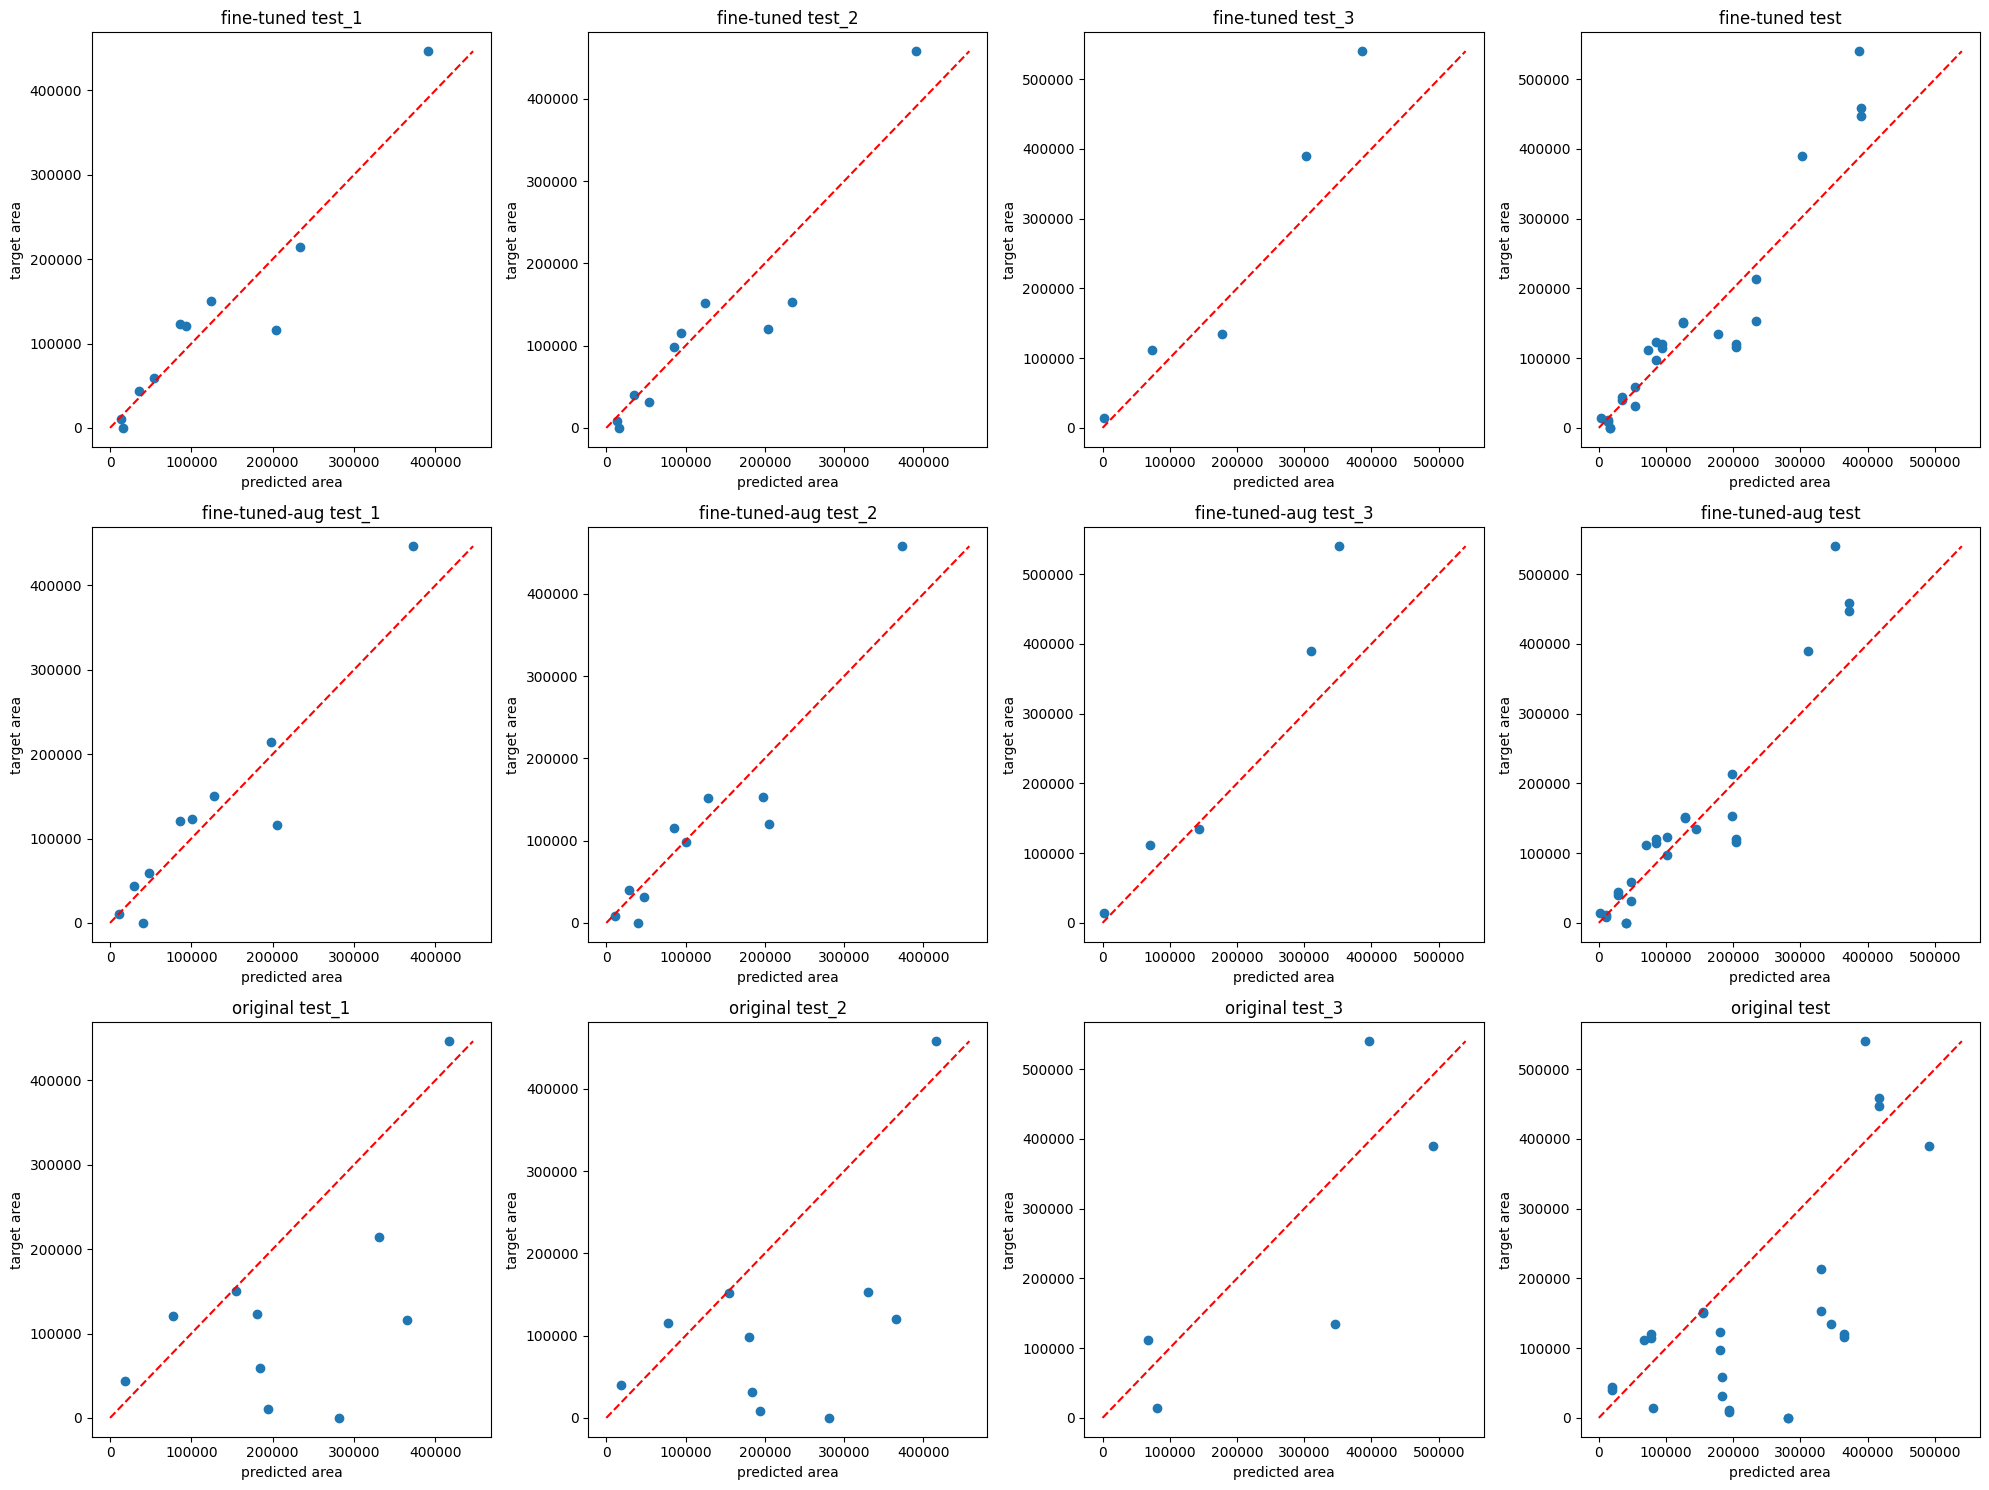

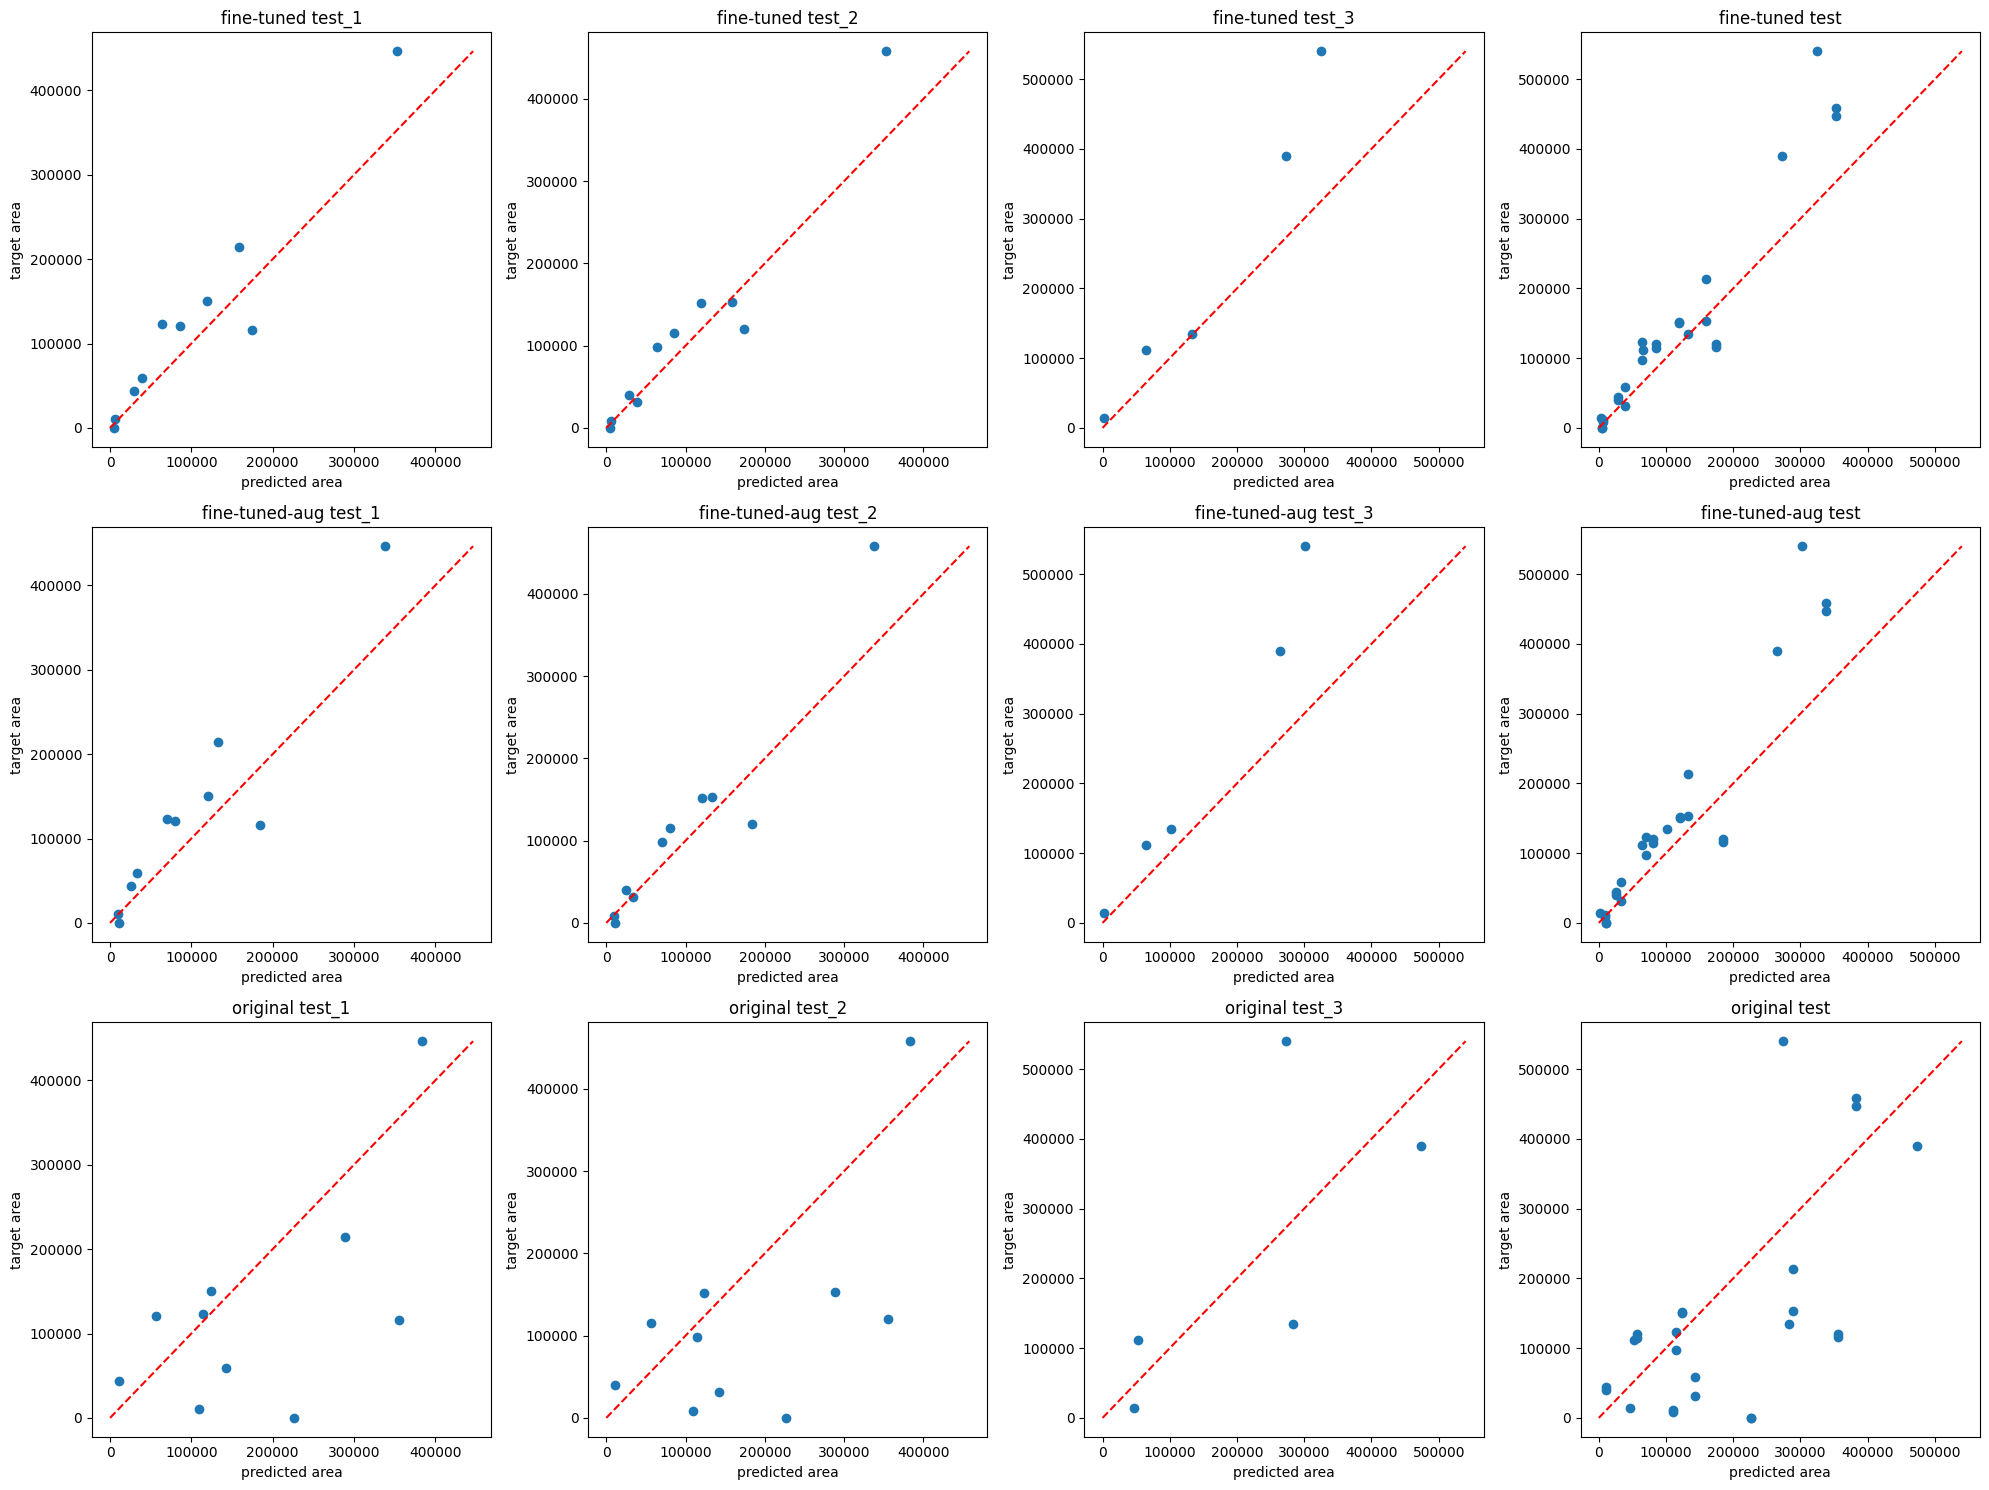

In [13]:
def create_subplot(ax, x, y, title):
    ax.plot(x, y, "o")
    m = max(max(x), max(y))
    ax.plot([0, m], [0, m], "r--")
    ax.set_title(title)
    ax.set_xlabel("predicted area")
    ax.set_ylabel("target area")


from matplotlib import pyplot as plt
# display area
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
conf = 0.8 # choose best conf
create_subplot(axes[0, 0], area[conf]["ft_1"], area[conf]["1"], "fine-tuned test_1")
create_subplot(axes[0, 1], area[conf]["ft_2"], area[conf]["2"], "fine-tuned test_2")
create_subplot(axes[0, 2], area[conf]["ft_3"], area[conf]["3"], "fine-tuned test_3")
create_subplot(axes[0, 3], area[conf]["ft"], area[conf]["target"], "fine-tuned test")
create_subplot(axes[1, 0], area[conf]["ft_aug_1"], area[conf]["1"], "fine-tuned-aug test_1")
create_subplot(axes[1, 1], area[conf]["ft_aug_2"], area[conf]["2"], "fine-tuned-aug test_2")
create_subplot(axes[1, 2], area[conf]["ft_aug_3"], area[conf]["3"], "fine-tuned-aug test_3")
create_subplot(axes[1, 3], area[conf]["ft_aug"], area[conf]["target"], "fine-tuned-aug test")
create_subplot(axes[2, 0], area[conf]["orig_1"], area[conf]["1"], "original test_1")
create_subplot(axes[2, 1], area[conf]["orig_2"], area[conf]["2"], "original test_2")
create_subplot(axes[2, 2], area[conf]["orig_3"], area[conf]["3"], "original test_3")
create_subplot(axes[2, 3], area[conf]["orig"], area[conf]["target"], "original test")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
conf = 0.9 # choose best conf
create_subplot(axes[0, 0], area[conf]["ft_1"], area[conf]["1"], "fine-tuned test_1")
create_subplot(axes[0, 1], area[conf]["ft_2"], area[conf]["2"], "fine-tuned test_2")
create_subplot(axes[0, 2], area[conf]["ft_3"], area[conf]["3"], "fine-tuned test_3")
create_subplot(axes[0, 3], area[conf]["ft"], area[conf]["target"], "fine-tuned test")
create_subplot(axes[1, 0], area[conf]["ft_aug_1"], area[conf]["1"], "fine-tuned-aug test_1")
create_subplot(axes[1, 1], area[conf]["ft_aug_2"], area[conf]["2"], "fine-tuned-aug test_2")
create_subplot(axes[1, 2], area[conf]["ft_aug_3"], area[conf]["3"], "fine-tuned-aug test_3")
create_subplot(axes[1, 3], area[conf]["ft_aug"], area[conf]["target"], "fine-tuned-aug test")
create_subplot(axes[2, 0], area[conf]["orig_1"], area[conf]["1"], "original test_1")
create_subplot(axes[2, 1], area[conf]["orig_2"], area[conf]["2"], "original test_2")
create_subplot(axes[2, 2], area[conf]["orig_3"], area[conf]["3"], "original test_3")
create_subplot(axes[2, 3], area[conf]["orig"], area[conf]["target"], "original test")
plt.tight_layout()
plt.show()
# draw a line on all the sublots




show plot with error

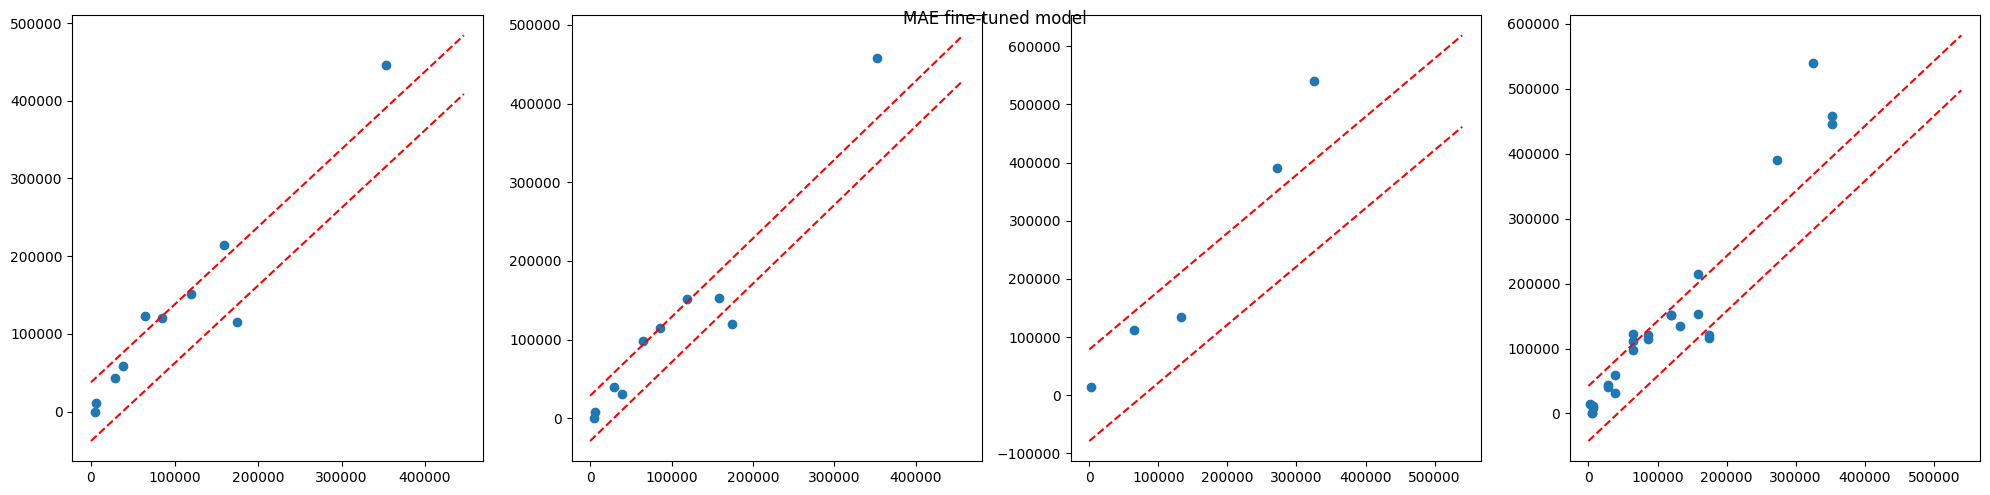

In [14]:
#MAE

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
conf = 0.9 # choose best conf

mae_1 = compute_error_mae(area[conf]["ft_1"], area[conf]["1"])
mae_2 = compute_error_mae(area[conf]["ft_2"], area[conf]["2"])
mae_3 = compute_error_mae(area[conf]["ft_3"], area[conf]["3"])
mae = compute_error_mae(area[conf]["ft"], area[conf]["target"])
axes[0].plot(area[conf]["ft_1"], area[conf]["1"], "o")
m = max(max(area[conf]["ft_1"]), max(area[conf]["1"]))
axes[0].plot([0, m], [mae_1, m + mae_1], "r--")
axes[0].plot([0, m], [-mae_1, m - mae_1], "r--")
axes[1].plot(area[conf]["ft_2"], area[conf]["2"], "o")
m = max(max(area[conf]["ft_2"]), max(area[conf]["2"]))
axes[1].plot([0, m], [mae_2, m + mae_2], "r--")
axes[1].plot([0, m], [-mae_2, m - mae_2], "r--")
axes[2].plot(area[conf]["ft_3"], area[conf]["3"], "o")    
m = max(max(area[conf]["ft_3"]), max(area[conf]["3"]))
axes[2].plot([0, m], [mae_3, m + mae_3], "r--")
axes[2].plot([0, m], [-mae_3, m - mae_3], "r--")
axes[3].plot(area[conf]["ft"], area[conf]["target"], "o")
m = max(max(area[conf]["ft"]), max(area[conf]["target"]))
axes[3].plot([0, m], [mae, m + mae], "r--")
axes[3].plot([0, m], [-mae, m - mae], "r--")
plt.tight_layout()
plt.suptitle("MAE fine-tuned model")
plt.show()


0.38082268724295765 0.31162709970698854 0.3439506731342358 0.3457700494068257


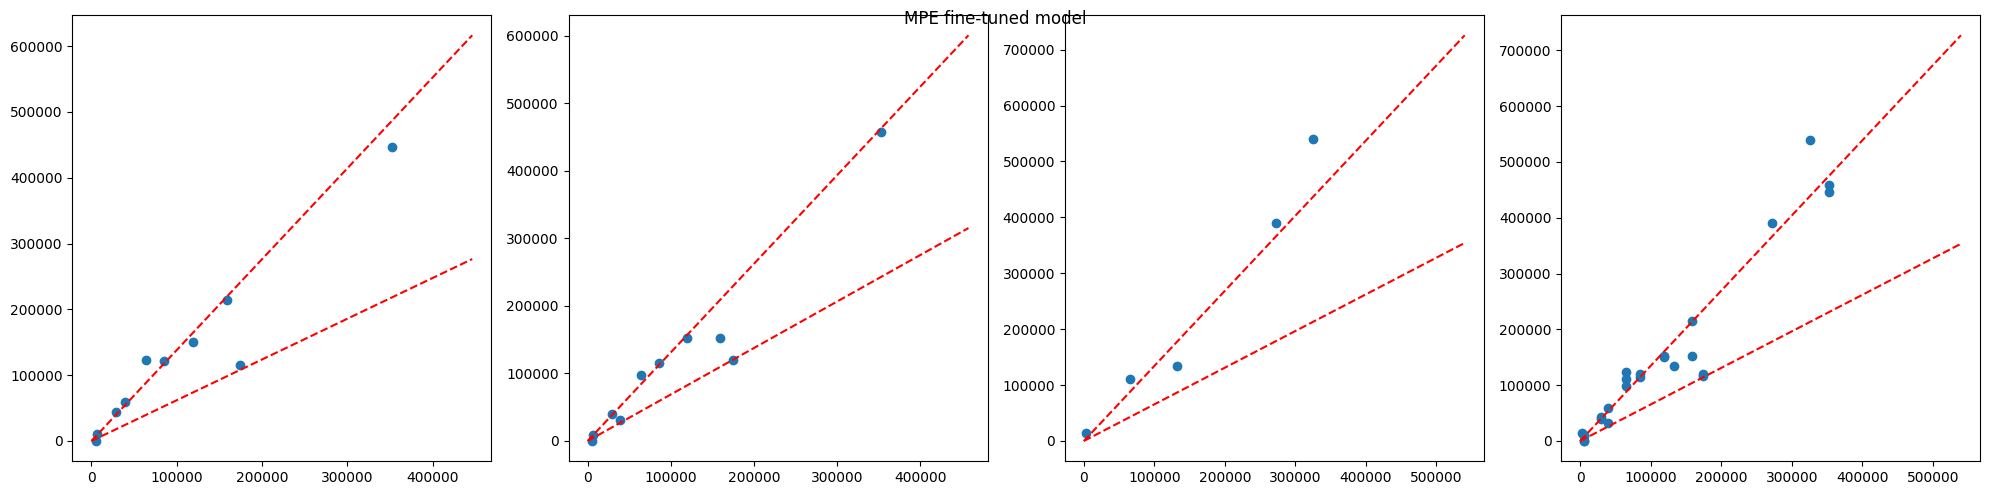

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
conf = 0.9 # choose best conf

mpe_1 = compute_error_mpe(area[conf]["ft_1"], area[conf]["1"])
mpe_2 = compute_error_mpe(area[conf]["ft_2"], area[conf]["2"])
mpe_3 = compute_error_mpe(area[conf]["ft_3"], area[conf]["3"])
mpe = compute_error_mpe(area[conf]["ft"], area[conf]["target"])
print(mpe_1, mpe_2, mpe_3, mpe)
axes[0].plot(area[conf]["ft_1"], area[conf]["1"], "o")
m = max(max(area[conf]["ft_1"]), max(area[conf]["1"]))
axes[0].plot([0, m], [0, m*(1 + mpe_1)], "r--")
axes[0].plot([0, m], [0, m*(1-mpe_1)], "r--")
axes[1].plot(area[conf]["ft_2"], area[conf]["2"], "o")
m = max(max(area[conf]["ft_2"]), max(area[conf]["2"]))
axes[1].plot([0, m], [0, m*(1 + mpe_2)], "r--")
axes[1].plot([0, m], [0, m*(1-mpe_2)], "r--")
axes[2].plot(area[conf]["ft_3"], area[conf]["3"], "o")    
m = max(max(area[conf]["ft_3"]), max(area[conf]["3"]))
axes[2].plot([0, m], [0, m*(1 + mpe_3)], "r--")
axes[2].plot([0, m], [0, m*(1-mpe_3)], "r--")
axes[3].plot(area[conf]["ft"], area[conf]["target"], "o")
m = max(max(area[conf]["ft"]), max(area[conf]["target"]))
axes[3].plot([0, m], [0, m*(1 + mpe)], "r--")
axes[3].plot([0, m], [0, m*(1-mpe)], "r--")
plt.tight_layout()
plt.suptitle("MPE fine-tuned model")
plt.show()

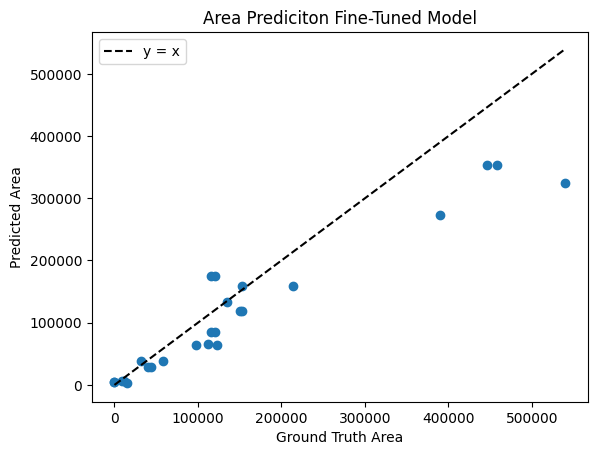

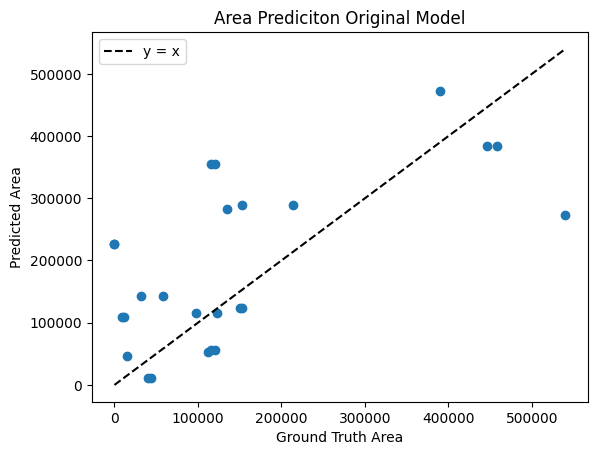

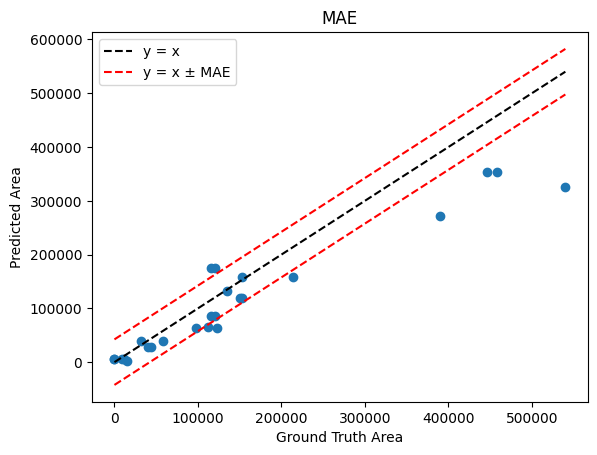

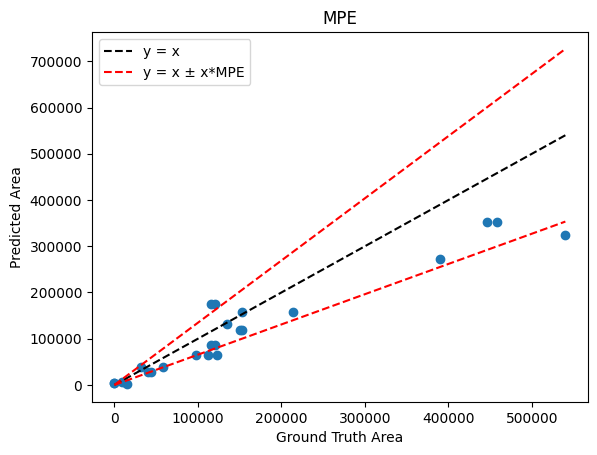

In [47]:
plt.title("Area Prediciton Fine-Tuned Model")
plt.plot(area[0.9]["target"], area[0.9]["ft"], 'o')
m = max(max(area[0.9]["ft"]), max(area[0.9]["target"]))
plt.plot([0, m], [0, m], "k--", label="y = x")
plt.ylabel("Predicted Area")
plt.xlabel("Ground Truth Area")
plt.legend()
plt.show()

plt.title("Area Prediciton Original Model")
plt.plot(area[0.9]["target"], area[0.9]["orig"], 'o')
m = max(max(area[0.9]["orig"]), max(area[0.9]["target"]))
plt.plot([0, m], [0, m], "k--", label="y = x")
plt.ylabel("Predicted Area")
plt.xlabel("Ground Truth Area")
plt.legend()
plt.show()

plt.title("MAE")
plt.plot(area[0.9]["target"], area[0.9]["ft"], 'o')
plt.plot([0, m], [0, m], "k--", label="y = x")
mae = compute_error_mae(area[0.9]["ft"], area[0.9]["target"])
m = max(max(area[0.9]["ft"]), max(area[0.9]["target"]))
plt.plot([0, m], [mae, m + mae], "r--", label="y = x ± MAE")
plt.plot([0, m], [-mae, m - mae], "r--")
plt.ylabel("Predicted Area")
plt.xlabel("Ground Truth Area")
plt.legend()
plt.show()

plt.title("MPE")
plt.plot(area[0.9]["target"], area[0.9]["ft"], 'o')
mpe = compute_error_mpe(area[0.9]["ft"], area[0.9]["target"])
plt.plot([0, m], [0, m], "k--", label="y = x")
m = max(max(area[0.9]["ft"]), max(area[0.9]["target"]))
plt.plot([0, m], [0, m*(1+mpe)], "r--", label="y = x ± x*MPE")
plt.plot([0, m], [0, m*(1-mpe)], "r--")
plt.ylabel("Predicted Area")
plt.xlabel("Ground Truth Area")
plt.legend()
plt.show()